In [4]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [5]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [6]:
ALL_DATA_DIR = '/home/HDD6TB/datasets/emotions/'
INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

---

In [7]:
AFFECT_DATA_DIR=ALL_DATA_DIR+'AffectNet/'
AFFECT_TRAIN_DATA_DIR = AFFECT_DATA_DIR+'full_res/train'
AFFECT_VAL_DATA_DIR = AFFECT_DATA_DIR+'full_res/val'
AFFECT_SEVEN_TRAIN_DATA_DIR = AFFECT_DATA_DIR+'full_res/seven_emotions/train'
AFFECT_SEVEN_VAL_DATA_DIR = AFFECT_DATA_DIR+'full_res/seven_emotions/val'

AFFECT_IMG_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/train'
AFFECT_IMG_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/val'
AFFECT_IMG_SEVEN_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/seven_emotions/train'
AFFECT_IMG_SEVEN_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/seven_emotions/val'
AFFECT_TRAIN_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/train'
AFFECT_VAL_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/val'

IMG_AFFECT_DATA_DIR = AFFECT_DATA_DIR+'Manually_Annotated_Images/'
AFFECT_TRAIN_FILE=AFFECT_DATA_DIR+'training.csv'
AFFECT_TRAIN_FILTERED_FILE=AFFECT_DATA_DIR+'training_filtered.csv'
AFFECT_VAL_FILE=AFFECT_DATA_DIR+'validation.csv'
AFFECT_VAL_FILTERED_FILE=AFFECT_DATA_DIR+'validation_filtered.csv'

AFFECT_TRAIN_ALIGNED_DATA_DIR = AFFECT_DATA_DIR+'full_res_aligned/train'# 8 emotions
AFFECT_VAL_ALIGNED_DATA_DIR = AFFECT_DATA_DIR+'full_res_aligned/val'
AFFECT_TRAIN_SEVEN_ALIGNED_DATA_DIR = AFFECT_DATA_DIR+'full_res_aligned/seven_emotions/train'# 7 emotions
AFFECT_VAL_SEVEN_ALIGNED_DATA_DIR = AFFECT_DATA_DIR+'full_res_aligned/seven_emotions/val'

In [5]:
import csv
def save_csv(filename,outfile, dir_to_save):
    affect_df = pd.read_csv(filename)
    affect_vals=[d for i,d in affect_df.iterrows()]
    with open(os.path.join(AFFECT_DATA_DIR,outfile), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['filepath','emotion','valence', 'arousal'])
        writer.writeheader()
        for d in affect_vals:
            #print(d.subDirectory_filePath,d.face_x,d.face_y, d.face_width, d.face_height, d.expression)
            if d.expression>=len(emotion_labels) or d.face_width<0:
                continue
            input_path=os.path.join(IMG_AFFECT_DATA_DIR,d.subDirectory_filePath)
            dst_file_path=os.path.join(emotion_labels[d.expression],os.path.basename(d.subDirectory_filePath))
            #print(input_path,dst_file_path)
            if os.path.exists(os.path.join(dir_to_save,dst_file_path)):
                #writer.writerow({'filepath':dst_file_path[len(AFFECT_DATA_DIR):],'emotion':emotion_labels[d.expression],'valence':d.valence, 'arousal':d.arousal})
                writer.writerow({'filepath':dst_file_path,'emotion':emotion_labels[d.expression],'valence':d.valence, 'arousal':d.arousal})

if False:
    save_csv(AFFECT_VAL_FILE,AFFECT_VAL_FILTERED_FILE,AFFECT_IMG_VAL_DATA_DIR)
    save_csv(AFFECT_TRAIN_FILE,AFFECT_TRAIN_FILTERED_FILE,AFFECT_IMG_TRAIN_DATA_DIR)


# Train

In [8]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


print(f"Torch: {torch.__version__}")

Torch: 1.7.1+cu110


In [9]:
# Training settings
batch_size = 64 #48# 32# 32 #16 #8 #
epochs = 40
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [10]:
#net_description='affectnet_'+net_description
train_dir,test_dir=AFFECT_TRAIN_DATA_DIR,AFFECT_VAL_DATA_DIR
#train_dir,test_dir=AFFECT_IMG_TRAIN_DATA_DIR,AFFECT_IMG_VAL_DATA_DIR
#train_dir,test_dir=AFFECT_SEVEN_TRAIN_DATA_DIR,AFFECT_SEVEN_VAL_DATA_DIR
#train_dir,test_dir=AFFECT_IMG_SEVEN_TRAIN_DATA_DIR,AFFECT_IMG_SEVEN_VAL_DATA_DIR
#train_dir,test_dir=AFFECT_TRAIN_ORIG_DATA_DIR,AFFECT_VAL_ORIG_DATA_DIR

#train_dir,test_dir=AFFECT_TRAIN_ALIGNED_DATA_DIR,AFFECT_VAL_ALIGNED_DATA_DIR
#train_dir,test_dir=AFFECT_TRAIN_SEVEN_ALIGNED_DATA_DIR,AFFECT_VAL_SEVEN_ALIGNED_DATA_DIR

print(train_dir,test_dir)

/home/HDD6TB/datasets/emotions/AffectNet/full_res/train /home/HDD6TB/datasets/emotions/AffectNet/full_res/val


In [2]:
USE_ENET2=True #False #

In [10]:
IMG_SIZE=260 if USE_ENET2 else 224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
print(test_transforms)

Compose(
    Resize(size=(260, 260), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [11]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

## FER only model 

In [12]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(test_dataset))

287651 4000


In [13]:
(unique, counts) = np.unique(train_dataset.targets, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights.values())

[ 24882   3750   3803   6378 134415  74874  25459  14090] dict_values([5.402097902097902, 35.844, 35.34446489613463, 21.07478833490122, 1.0, 1.7952159628175335, 5.279665344279037, 9.539744499645138])


In [14]:
num_classes=len(train_dataset.classes)
print(num_classes)

8


In [72]:
# loss function
weights = torch.FloatTensor(list(class_weights.values())).cuda()
if False:
    criterion = nn.CrossEntropyLoss(weight=weights)
    #criterion = nn.CrossEntropyLoss()
else:
    def label_smooth(target, n_classes: int, label_smoothing=0.1):
        # convert to one-hot
        batch_size = target.size(0)
        target = torch.unsqueeze(target, 1)
        soft_target = torch.zeros((batch_size, n_classes), device=target.device)
        soft_target.scatter_(1, target, 1)
        # label smoothing
        soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
        return soft_target

    def cross_entropy_loss_with_soft_target(pred, soft_target):
        #logsoftmax = nn.LogSoftmax(dim=-1)
        return torch.mean(torch.sum(- weights*soft_target * torch.nn.functional.log_softmax(pred, -1), 1))

    def cross_entropy_with_label_smoothing(pred, target):
        soft_target = label_smooth(target, pred.size(1)) #num_classes) #
        return cross_entropy_loss_with_soft_target(pred, soft_target)

    criterion=cross_entropy_with_label_smoothing

In [73]:
from robust_optimization import RobustOptimizer
import copy
def train(model,n_epochs=epochs, learningrate=lr, robust=False):
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learningrate)
        #print(optimizer)
    else:
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            if robust:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc = (output.argmax(dim=1) == label).float().sum()
            epoch_accuracy += acc
            epoch_loss += loss
        epoch_accuracy /= len(train_dataset)
        epoch_loss /= len(train_dataset)
        
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
        epoch_val_accuracy /= len(test_dataset)
        epoch_val_loss /= len(test_dataset)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        if best_acc<epoch_val_accuracy:
            best_acc=epoch_val_accuracy
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
        epoch_val_accuracy /= len(test_dataset)
        epoch_val_loss /= len(test_dataset)
        print(
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
    else:
        print(f"No best model Best acc:{best_acc}")

### Finetune CNN 

In [16]:
from torchvision.models import resnet101,mobilenet_v2
import timm

In [22]:
model=timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load('../../models/pretrained_faces/state_vggface2_enet0_new.pt')) #_new

<All keys matched successfully>

In [23]:
model.classifier=nn.Sequential(nn.Linear(in_features=1280, out_features=num_classes)) #1792 #1280 #1536
#model.head.fc=nn.Linear(in_features=3072, out_features=num_classes)
#model.head=nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
model=model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [24]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.classifier, requires_grad=True)
train(model,3,0.001,robust=True)
#Best acc:0.48875007033348083
#7: Best acc:0.558712363243103

RobustOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    rho: 0.05
    weight_decay: 0
)


  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 1 - loss : 8.7285 - acc: 0.3183 - val_loss : 19.7174 - val_acc: 0.4869



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 2 - loss : 8.5475 - acc: 0.3424 - val_loss : 18.7865 - val_acc: 0.4638



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 3 - loss : 8.4976 - acc: 0.3496 - val_loss : 20.5805 - val_acc: 0.5122

Best acc:0.5121527314186096
val_loss : 20.5805 - val_acc: 0.5122



In [25]:
set_parameter_requires_grad(model, requires_grad=True)
train(model,6,1e-4,robust=True)

RobustOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    rho: 0.05
    weight_decay: 0
)


  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 1 - loss : 7.8319 - acc: 0.4324 - val_loss : 17.3616 - val_acc: 0.5866



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 2 - loss : 7.3434 - acc: 0.5143 - val_loss : 16.1981 - val_acc: 0.5930



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 3 - loss : 7.1074 - acc: 0.5596 - val_loss : 16.4687 - val_acc: 0.6148



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 4 - loss : 6.9050 - acc: 0.5878 - val_loss : 16.4436 - val_acc: 0.6245



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 5 - loss : 6.7000 - acc: 0.6134 - val_loss : 16.4840 - val_acc: 0.6111



  0%|          | 0/4495 [00:00<?, ?it/s]

Epoch : 6 - loss : 6.4829 - acc: 0.6385 - val_loss : 18.0842 - val_acc: 0.6099

Best acc:0.6245041489601135
val_loss : 16.4436 - val_acc: 0.6245



In [3]:
if USE_ENET2:
    if False: # 7 emotions
        PATH='../../models/affectnet_emotions/enet_b2_7.pt'
        model_name='enet2_7_pt'
    else:
        #PATH='../../models/affectnet_emotions/enet_b2_8.pt'
        PATH='../../models/affectnet_emotions/enet_b2_8_best.pt'
        model_name='enet2_8_pt'
else:
    if False: # 7 emotions from AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR
        PATH='../../models/affectnet_emotions/enet_b0_7.pt'
        model_name='enet0_7_pt'
    else:
        PATH='../../models/affectnet_emotions/enet_b0_8_best_vgaf.pt'
        #PATH='../../models/affectnet_emotions/enet_b0_8_best_afew.pt'
        model_name='enet0_8_pt'
print(PATH)

../../models/affectnet_emotions/enet_b2_8_best.pt


In [31]:
# Save
torch.save(model, PATH)

In [11]:
# Load
print(PATH)
model = torch.load(PATH)
model=model.eval()

../../models/affectnet_emotions/enet_b2_8_best.pt


In [17]:
class_to_idx=train_dataset.class_to_idx
print(class_to_idx)
idx_to_class={idx:cls for cls,idx in class_to_idx.items()}
print(idx_to_class)

{'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happiness': 4, 'Neutral': 5, 'Sadness': 6, 'Surprise': 7}
{0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}


In [18]:
print(test_dir)
y_val,y_scores_val=[],[]
model.eval()
for class_name in tqdm(os.listdir(test_dir)):
    if class_name in class_to_idx:
        class_dir=os.path.join(test_dir,class_name)
        y=class_to_idx[class_name]
        for img_name in os.listdir(class_dir):
            filepath=os.path.join(class_dir,img_name)
            img = Image.open(filepath)
            img_tensor = test_transforms(img)
            img_tensor.unsqueeze_(0)
            scores = model(img_tensor.to(device))
            scores=scores[0].data.cpu().numpy()
            #print(scores.shape)
            y_scores_val.append(scores)
            y_val.append(y)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

/home/HDD6TB/datasets/emotions/AffectNet/full_res/val


  0%|          | 0/8 [00:00<?, ?it/s]

(4000, 8) (4000,)


In [23]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(train_dataset.targets)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

63.125
Anger 24882/500 acc: 54.600000
Contempt 3750/500 acc: 65.600000
Disgust 3803/500 acc: 65.600000
Fear 6378/500 acc: 66.400000
Happiness 134415/500 acc: 71.600000
Neutral 74874/500 acc: 53.400000
Sadness 25459/500 acc: 66.600000
Surprise 14090/500 acc: 61.200000


In [24]:
#-Contempt
сontempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=сontempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred_filtered=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=сontempt_idx
y_val_new=np.array([y if y<сontempt_idx else y-1 for y in y_val if y!=сontempt_idx])
acc=100.0*np.mean(y_val_new==y_pred_filtered[other_indices])
print(acc)

(4000, 7)
66.51428571428572


['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
(4000,) (4000,) 0.63125


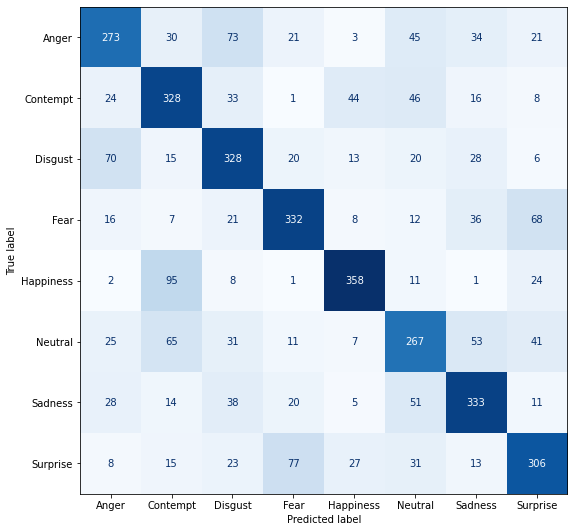

In [25]:
labels=list(class_to_idx.keys())
print(labels)
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False) #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_pred,labels)

['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
(3500,) (3500,) 0.6651428571428571


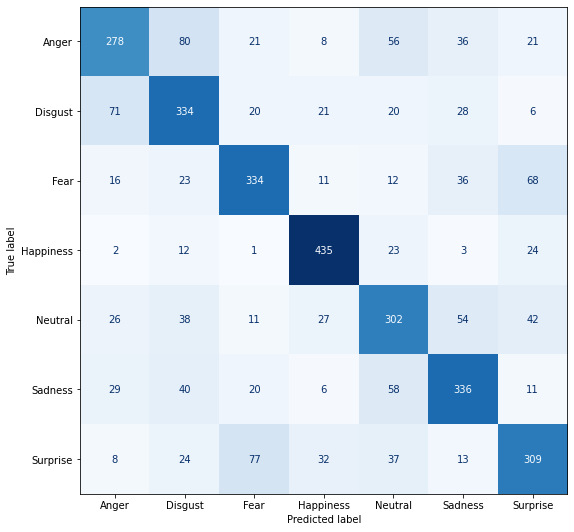

In [26]:
labels_7=[idx_to_class[i] for i in idx_to_class if i!=сontempt_idx]#list(class_to_idx.keys())
print(labels_7)
plt_conf_matrix(y_val_new, y_pred_filtered[other_indices],labels_7)

## Multi-task: FER+Valence-Arousal 

In [31]:
affectnet_expr2emotion={0:'Neutral',1:'Happiness', 2:'Sadness', 3:'Surprise', 4:'Fear', 5:'Disgust', 6:'Anger', 7:'Contempt'}
idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
#idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}


In [57]:
class MultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self,csv_file, root, transform):
        df=pd.read_csv(csv_file)
        df=df[df['emotion'].isin(class_to_idx.keys())]
        self.paths = list(df.filepath)#[:4000]
        self.targets = np.array([class_to_idx[cls] for cls in df.emotion])#[:4000]
        self.valence_arousal = df[['valence','arousal']].to_numpy()#[:4000]
        self.transform = transform
        self.root=root

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = Image.open(os.path.join(self.root,self.paths[idx])).convert('RGB')
        img = self.transform(img)

        #dealing with the labels
        emotion_label = self.targets[idx]
        valence=torch.tensor(float(self.valence_arousal[idx,0]), dtype=torch.float32)
        arousal=torch.tensor(float(self.valence_arousal[idx,1]), dtype=torch.float32)
        
        return img.data, (emotion_label, valence, arousal)

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

batch_size=48
train_dataset = MultiTaskDataset(csv_file=AFFECT_TRAIN_FILTERED_FILE, root=train_dir, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_dataset = MultiTaskDataset(csv_file=AFFECT_VAL_FILTERED_FILE,root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(test_dataset))

287651 4000


In [47]:
(unique, counts) = np.unique(train_dataset.targets, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights.values())

num_classes=len(class_to_idx)
print(num_classes)

[ 24882   3750   3803   6378 134416  74874  25459  14090] dict_values([5.4021380917932635, 35.84426666666667, 35.344727846437024, 21.07494512386328, 1.0, 1.7952293185885622, 5.2797046231195255, 9.539815471965934])
8


In [16]:
import timm
model=timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load('../../models/pretrained_faces/state_vggface2_enet0_new.pt')) #_new
model.classifier=nn.Linear(in_features=1280, out_features=num_classes+2) #1792 #1280 #1536 #1408
model=model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [34]:
def ConcordanceCorCoeff(prediction, ground_truth):
    mean_gt = torch.mean (ground_truth, 0)
    mean_pred = torch.mean (prediction, 0)
    var_gt = torch.var (ground_truth, 0)
    var_pred = torch.var (prediction, 0)
    v_pred = prediction - mean_pred
    v_gt = ground_truth - mean_gt
    cor = torch.sum (v_pred * v_gt) / (torch.sqrt(torch.sum(v_pred ** 2)) * torch.sqrt(torch.sum(v_gt ** 2)))
    sd_gt = torch.std(ground_truth)
    sd_pred = torch.std(prediction)
    numerator=2*cor*sd_gt*sd_pred
    denominator=var_gt+var_pred+(mean_gt-mean_pred)**2
    ccc = numerator/denominator
    return ccc

def ConcordanceCorCoeffLoss(prediction, ground_truth):
    return (1-ConcordanceCorCoeff(prediction, ground_truth))/2

In [35]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self):
        super(MultiTaskLossWrapper, self).__init__()
        #self.task_num = 3
        #self.log_vars = nn.Parameter(torch.zeros((self.task_num)))
        weights = torch.FloatTensor(list(class_weights.values())).to(device)
        self.loss_emotions = nn.CrossEntropyLoss(weight=weights)
        self.loss_valence=ConcordanceCorCoeffLoss #nn.MSELoss()
        self.loss_arousal=ConcordanceCorCoeffLoss #nn.MSELoss()

    def forward(self, preds, target):
        loss_emotions=self.loss_emotions(preds[:,:num_classes],target[0])
        loss_valence=self.loss_valence(preds[:,num_classes],target[1])
        loss_arousal=self.loss_arousal(preds[:,num_classes+1],target[2])
        return loss_emotions+(loss_valence+loss_arousal)*1
my_criterion=MultiTaskLossWrapper()

In [36]:
from robust_optimization import RobustOptimizer
import copy
def train(model,n_epochs=epochs, learningrate=lr, robust=False):
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learningrate)
        #print(optimizer)
    else:
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_mse_valence=epoch_mse_arousal=0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = [l.to(device) for l in label]
            
            output = model(data)
            loss = my_criterion(output, label)

            if robust:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                loss = my_criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc = (output[:,:num_classes].argmax(dim=1) == label[0]).float().sum()
            epoch_accuracy += acc
            
            mse_valense = ((output[:,num_classes] - label[1])**2).float().sum()
            epoch_mse_valence += mse_valense
            mse_arousal = ((output[:,num_classes+1] - label[2])**2).float().sum()
            epoch_mse_arousal += mse_arousal
            
            epoch_loss += loss

        epoch_accuracy /= len(train_dataset)
        mse_valense /= len(train_dataset)
        mse_arousal /= len(train_dataset)
        epoch_loss /= len(train_dataset)

        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            epoch_val_mse_valence=epoch_val_mse_arousal=0
            for data, label in test_loader:
                data = data.to(device)
                label = [l.to(device) for l in label]
                
                val_output = model(data)
                val_loss = my_criterion(val_output, label)

                acc = (val_output[:,:num_classes].argmax(dim=1) == label[0]).float().sum()
                epoch_val_accuracy += acc

                mse_valense = ((val_output[:,num_classes] - label[1])**2).float().sum()
                epoch_val_mse_valence += mse_valense
                mse_arousal = ((val_output[:,num_classes+1] - label[2])**2).float().sum()
                epoch_val_mse_arousal += mse_arousal
                epoch_val_loss += val_loss
        
        epoch_val_accuracy /= len(test_dataset)
        epoch_val_mse_valence /= len(test_dataset)
        epoch_val_mse_arousal /= len(test_dataset)
        epoch_val_loss /= len(test_dataset)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - mse (valence): {epoch_mse_valence:.4f} - mse (arousal): {epoch_mse_arousal:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - val_mse (valence): {epoch_val_mse_valence:.4f} - val_mse (arousal): {epoch_val_mse_arousal:.4f}\n"
        )
        if best_acc<epoch_val_accuracy:
            best_acc=epoch_val_accuracy
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
    else:
        print(f"No best model Best acc:{best_acc}")

In [ ]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.classifier, requires_grad=True)
train(model,3,0.001,robust=True)

In [ ]:
set_parameter_requires_grad(model, requires_grad=True)
train(model,6,1e-4,robust=True)

In [12]:
PATH='../../models/affectnet_emotions/enet_b0_8_va_mtl.pt'
model_name='enet0_8_mtl_pt'

In [13]:
print(PATH)
if False:
    torch.save(model, PATH)
else:
    model = torch.load(PATH)

../../models/affectnet_emotions/enet_b0_8_va_mtl.pt


In [61]:
model=model.to(device)
model.eval()
with torch.no_grad():
    epoch_val_accuracy = 0
    epoch_val_mse_valence=epoch_val_mse_arousal=0
    for data, label in test_loader:
        data = data.to(device)
        label = [l.to(device) for l in label]

        val_output = model(data)

        acc = (val_output[:,:num_classes].argmax(dim=1) == label[0]).float().sum()
        epoch_val_accuracy += acc

        mse_valense = ((val_output[:,num_classes] - label[1])**2).float().sum()
        epoch_val_mse_valence += mse_valense
        mse_arousal = ((val_output[:,num_classes+1] - label[2])**2).float().sum()
        epoch_val_mse_arousal += mse_arousal
epoch_val_accuracy /= len(test_dataset)
epoch_val_mse_valence /= len(test_dataset)
epoch_val_mse_arousal /= len(test_dataset)
print(
    f"val_acc: {epoch_val_accuracy:.4f} - val_mse (valence): {epoch_val_mse_valence:.4f} - val_mse (arousal): {epoch_val_mse_arousal:.4f}\n"
)

val_acc: 0.6193 - val_mse (valence): 0.1880 - val_mse (arousal): 0.1496



In [49]:
y_val,y_scores_val=[],[]
model.eval()
for class_name in tqdm(os.listdir(test_dir)):
    if class_name in class_to_idx:
        class_dir=os.path.join(test_dir,class_name)
        y=class_to_idx[class_name]
        for img_name in os.listdir(class_dir):
            filepath=os.path.join(class_dir,img_name)
            img = Image.open(filepath)
            img_tensor = test_transforms(img)
            img_tensor.unsqueeze_(0)
            scores = model(img_tensor.to(device))
            scores=scores[0].data.cpu().numpy()
            #print(scores.shape)
            y_scores_val.append(scores[:-2])
            y_val.append(y)

  0%|          | 0/8 [00:00<?, ?it/s]

In [50]:
y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(train_dataset.targets)
for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

#-Contempt
сontempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=сontempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=сontempt_idx
y_val_new=np.array([y if y<сontempt_idx else y-1 for y in y_val if y!=сontempt_idx])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(4000, 8) (4000,)
61.925
Anger 24882/500 acc: 64.000000
Contempt 3750/500 acc: 57.800000
Disgust 3803/500 acc: 53.800000
Fear 6378/500 acc: 56.200000
Happiness 134416/500 acc: 81.000000
Neutral 74874/500 acc: 55.800000
Sadness 25459/500 acc: 64.600000
Surprise 14090/500 acc: 62.200000
(4000, 7)
64.97142857142858


In [51]:
affect_df = pd.read_csv(AFFECT_VAL_FILE)
X_VA_val=[]
VA_preds=[]
for i,d in tqdm(affect_df.iterrows()):
    if d.expression not in affectnet_expr2emotion:
        continue
    X_VA_val.append([d.valence, d.arousal])
    img = Image.open(os.path.join(test_dir,affectnet_expr2emotion[d.expression],os.path.basename(d.subDirectory_filePath))).convert('RGB')
    img_tensor = test_transforms(img)
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    VA_preds.append([scores[-2],scores[-1]])
X_VA_val=np.array(X_VA_val)
VA_preds=np.array(VA_preds)
print(X_VA_val.shape,VA_preds.shape)

0it [00:00, ?it/s]

(4000, 2) (4000, 2)


In [52]:
print('Valence,Arousal')
mse=((X_VA_val-VA_preds)**2).mean(axis=0)
print('MSE',mse)
print('RMSE',np.sqrt(mse))
print('MAE',abs((X_VA_val-VA_preds)).mean(axis=0))
print('CCC',ConcordanceCorCoeff(torch.from_numpy(X_VA_val[:,0]),torch.from_numpy(VA_preds[:,0])).numpy(),
      ConcordanceCorCoeff(torch.from_numpy(X_VA_val[:,1]),torch.from_numpy(VA_preds[:,1])).numpy())

Valence,Arousal
MSE [0.18803859 0.14956716]
RMSE [0.43363417 0.38673914]
MAE [0.31258092 0.30441801]
CCC 0.5936892154066524 0.5486192135795945


## Example usage 

In [41]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [42]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

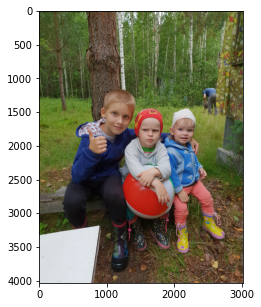

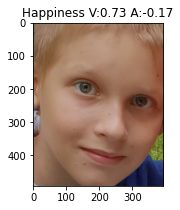

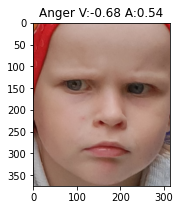

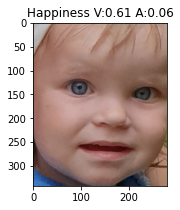

In [47]:
import matplotlib.pyplot as plt
fpath='../test_images/20180720_174416.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(face_img)
    if False:
        plt.title(idx_to_class[np.argmax(scores)])
    else:
        plt.title(f"{idx_to_class[np.argmax(scores[:8])]} V:{scores[8]:.2f} A:{scores[9]:.2f}")

In [48]:
imgProcessing.close()

### Feature extractor 

In [9]:
feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

# AFEW

In [10]:
DATA_DIR=os.path.join(ALL_DATA_DIR,'EmotiW/AFEW/')
print(DATA_DIR)
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

/home/HDD6TB/datasets/emotions/EmotiW/AFEW/


In [13]:
def get_features(data_dir):
    filename2features={}
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)
        X_global_features,X_isface=[],[]
        imgs=[]
        for img_name in os.listdir(frames_dir):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            X_isface.append('noface' not in img_name)
                
            if img.size:
                imgs.append(img_tensor)
                if len(imgs)>=16:        
                    #global_features,feats,scores=feature_extractor_model.predict(inp)
                    scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                    scores=scores.data.cpu().numpy()
                    #print(scores.shape)
            
                    #print(global_features.shape,feats.shape,scores.shape)
                    if len(X_global_features)==0:
                        X_global_features=scores
                    else:
                        X_global_features=np.concatenate((X_global_features,scores),axis=0)
                    
                    imgs=[]

        if len(imgs)>0:        
            scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            scores=scores.data.cpu().numpy()
            #print(scores.shape)

            #print(global_features.shape,feats.shape,scores.shape)
            if len(X_global_features)==0:
                X_global_features=scores
            else:
                X_global_features=np.concatenate((X_global_features,scores),axis=0)

        X_isface=np.array(X_isface)
        #print(X_global_features.shape,X_feats.shape,X_scores.shape)
        filename2features[filename]=(X_global_features,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames_mtcnn_cropped/'))
filename2features_train=get_features(os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames_mtcnn_cropped/')) #_cropped

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

In [35]:
import pickle
MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw.pickle' #'_feat_bgr_emotiw.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_new1_pt_feat_emotiw.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_emotiw.pickle'
print(MODEL2EMOTIW_FEATURES)

enet2_8_pt_feat_emotiw.pickle


In [49]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [269]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [14]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for category in emotion_to_index:
        for filename in os.listdir(os.path.join(data_dir,category)):
            fn=os.path.splitext(filename)[0]
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            if True:
                #prev=features[0].shape
                cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[category])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'))

(773, 5120) (773,)
(383, 5120) (383,)


In [15]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [23]:
#clf = svm.LinearSVC(C=3.5) #0.5 1.1
clf = svm.LinearSVC(C=1.1) 
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5989445910290238
Complete accuracy: 0.5926892950391645


# VGAF

In [33]:
DATA_DIR='/home/HDD6TB/datasets/emotions/EmotiW/VGAF/'
print(DATA_DIR)
emotion_to_index = {'Positive':1, 'Neutral':2, 'Negative':3}

/home/HDD6TB/datasets/emotions/EmotiW/VGAF/


In [ ]:
def get_features_scores(data_dir):
    videoname2features={}
    for videoname in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,videoname)
        X_global_features=[]
        for filename in sorted(os.listdir(frames_dir)):
            faces_dir=os.path.join(frames_dir,filename)
            imgs=[]
            global_features=[]
            for img_name in sorted(os.listdir(faces_dir)):
                img = Image.open(os.path.join(faces_dir,img_name))
                img_tensor = test_transforms(img)
                
                if img.size:
                    imgs.append(img_tensor)
                    if len(imgs)>=32:        
                        #global_features,feats,scores=feature_extractor_model.predict(inp)
                        scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        #print(scores.shape)

                        if len(global_features)==0:
                            global_features=scores
                        else:
                            global_features=np.concatenate((global_features,scores),axis=0)

                        imgs=[]


            if len(imgs)>0:        
                scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                scores=scores.data.cpu().numpy()
                #print(scores.shape)

                if len(global_features)==0:
                    global_features=scores
                else:
                    global_features=np.concatenate((global_features,scores),axis=0)
                #print(videoname,filename,global_features.shape)
                X_global_features.append(global_features)
        
        #print(videoname,len(X_global_features))
        videoname2features[videoname]=X_global_features
    return videoname2features

video2Allfeatures_val=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Val/mtcnn_aligned'))
video2Allfeatures_train=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Train/mtcnn_aligned'))

  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/2661 [00:00<?, ?it/s]

In [34]:
#model_name='mobilenet_v1_ft'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf.pickle' #'_feat_bgr_emotiw.pickle'
MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw_cropped.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_new1_pt_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_vgaf_aligned.pickle'
print(MODEL2EMOTIW_FEATURES)

enet2_8_pt_feat_vgaf_aligned.pickle


In [109]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([video2Allfeatures_train,video2Allfeatures_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    video2Allfeatures_train,video2Allfeatures_val=pickle.load(handle)
print(len(video2Allfeatures_train),len(video2Allfeatures_val))

2661 766


In [39]:
import csv
def create_dataset(videoname2features,labelsfile):
    x = []
    y = []
    has_faces=[]
    ind=0
    with open(labelsfile, mode='r') as csvfile:
        labels_reader = csv.reader(csvfile, delimiter=' ')
        for i,row in enumerate(labels_reader):
            if i==0:
                #print('first:',row)
                continue
            videoname,label=row[0],int(row[1])
            X_global_features=videoname2features[videoname]
            #print(videoname,label,len(X_global_features))
            
            total_features=[]
            for cur_features in X_global_features:
                #print(cur_features.shape)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature=max_features
                
                total_features.append(feature)
            
            if len(total_features)>0:
                total_features=np.array(total_features)
                mean_features = (np.mean(total_features, axis=0))
                std_features = (np.std(total_features, axis=0))
                max_features = (np.max(total_features, axis=0))
                min_features = (np.min(total_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature=max_features
                x.append(feature)
                has_faces.append(1)
            else:
                x.append(np.zeros_like(feature))
                has_faces.append(0)
            y.append(label-1)
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(video2Allfeatures_train,os.path.join(DATA_DIR,'Train_labels.txt'))
x_test, y_test, has_faces_test = create_dataset(video2Allfeatures_val,os.path.join(DATA_DIR,'Val_labels.txt'))

(2661, 5632) (2661,)
(766, 5632) (766,)


In [40]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [41]:
#clf = svm.LinearSVC(C=0.01) #0.25 0.5
clf = svm.SVC(kernel='rbf',C=1.9)
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7044534412955465
Complete accuracy: 0.7023498694516971
